This notebook allows to reproduce Figures 4 and 5 from Pessi *et al.*, 2024, *ELEPHANT: ExtragaLactic alErt Pipeline for Hostless AstroNomical Transients*

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.stats import multivariate_normal, wasserstein_distance
from astropy.visualization import simple_norm
import pandas as pd

os.chdir('../src/')
import powerspectrum as ps
os.chdir('../plots/')

In [2]:
import matplotlib

colors={"orange":"#ED9145",
        "dark_brown":"#473832",
        "beige":"#E2D3C1",
        "rose":"#BC7E74",
        "dark_blue":"#21609D",
        "light_blue":"#5C92C1",
        "dark_gray":"#4D5966",
        "black":"#27242A",
        "light_gray":"#8999A1",
        "golden_brown":"#87581D"}

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [colors['dark_blue'],
                                                                colors['orange']])

## Plot real data

In [3]:
objectID = 'ZTF18aajwbhh'

# Load in the science image and the associated segmentation mask from SExtractor
sci_seg = fits.open(f'../data/{objectID}_SCI_0145_SEG.fits')
sci_image = fits.open(f'../data/{objectID}_SCI_0145.fits')

# Load in the template image and the associated segmentation mask from SExtractor
temp_seg = fits.open(f'../data/{objectID}_TEMP_0145_SEG.fits')
temp_image = fits.open(f'../data/{objectID}_TEMP_0145.fits')

In [19]:
N_iter = 1000
size = 7

_, _, real_Abins_dict, shuffled_Abins_dict = \
           ps.detect_host_with_powerspectrum(tpl_image=temp_image[0].data, number_of_iterations=N_iter,
                                             metric='kstest', cutout_sizes=[size])


WD_dist_real_to_shuffled = []
WD_dist_shuffled_to_shuffled = []

for n in range(N_iter):

    iter1 = shuffled_Abins_dict[size][n]
    wd = wasserstein_distance(iter1, real_Abins_dict[size])
    WD_dist_real_to_shuffled.append(wd)

    for m in range(N_iter):
        if m >= n:
            continue
        
        iter2 = shuffled_Abins_dict[size][m]
        wd = wasserstein_distance(iter1, iter2)
        WD_dist_shuffled_to_shuffled.append(wd)

WD_dist_real_to_shuffled = np.array(WD_dist_real_to_shuffled)
WD_dist_shuffled_to_shuffled = np.array(WD_dist_shuffled_to_shuffled)

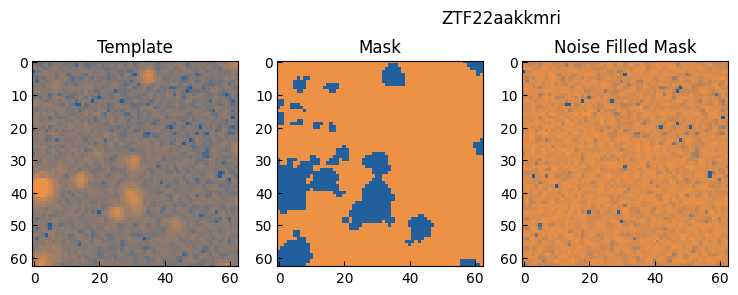

In [20]:
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled)),
                 np.log10(max(WD_dist_shuffled_to_shuffled)), 50)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create subplots to show all 
fig, ax = plt.subplots(1, 3, figsize=(7.5, 5))
fig.suptitle(objectID, y=0.775, x=0.675)

# Show the template image
norm0 = simple_norm(temp_image[0].data, 'log', percent=99.)
ax[0].imshow(temp_image[0].data, norm=norm0, cmap=cmap)
ax[0].tick_params(axis='both',direction='in')
ax[0].set_title('Template')

# Show the SExtractor mask for the template image
mask = temp_seg[0].data == 0
norm1 = simple_norm(np.where(mask, temp_image[0].data, -9999), 'log', percent=99.)
ax[1].imshow(np.where(mask, temp_image[0].data, -9999), norm=norm1, cmap=cmap)
ax[1].tick_params(axis='both',direction='in')
ax[1].set_title('Mask')

# Show the masked template image with the masked locations filled with random noise
mask = temp_seg[0].data > 0
for_filling = np.random.normal(np.median(temp_image[0].data[~mask]), np.std(temp_image[0].data[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, temp_image[0].data)
tpl_data = to_fill + for_filling

norm2 = simple_norm(tpl_data, 'log', percent=99.)
ax[2].imshow(tpl_data, norm=norm2,  
             cmap=cmap)
ax[2].tick_params(axis='both',direction='in')
ax[2].set_title('Noise Filled Mask')

fig.tight_layout()
plt.show()
#fig.savefig('ZTF18aajwbhh_stamps.pdf', bbox_inches='tight')

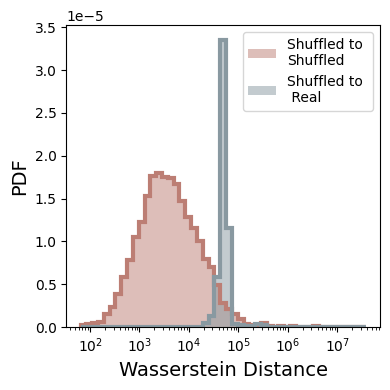

In [35]:
#bins = np.linspace(min(WD_dist_shuffled_to_shuffled), max(WD_dist_shuffled_to_shuffled), 50)
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled)),
                 np.log10(max(WD_dist_shuffled_to_shuffled)), 50)

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.hist(WD_dist_shuffled_to_shuffled, bins, color=colors['rose'], alpha=0.5, density=True, 
        label='Shuffled to ' + '\n' + 'Shuffled');
ax.hist(WD_dist_shuffled_to_shuffled, bins, color=colors['rose'], histtype='step', lw=3, density=True);

ax.hist(WD_dist_real_to_shuffled, bins, color=colors['light_gray'], alpha=0.5, density=True, 
        label='Shuffled to \n Real');
ax.hist(WD_dist_real_to_shuffled, bins, color=colors['light_gray'], histtype='step', lw=3, density=True);

ax.set_xlabel('Wasserstein Distance',fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
ax.set_xscale('log')
ax.legend(loc='upper right', fontsize=10)
fig.tight_layout()
plt.show()
#plt.savefig('ZTF18aajwbhh_hist.pdf', bbox_inches='tight')

In [13]:
objectID = 'ZTF22aakkmri'

# Load in the science image and the associated segmentation mask from SExtractor
sci_seg2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_SCI_0010_SEG.fits')
sci_image2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_SCI_0010_CAT.fits')

# Load in the template image and the associated segmentation mask from SExtractor
temp_seg2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_TEMP_0010_SEG.fits')
temp_image2 = fits.open(f'/media3/CRP7/hosts/data/EXTRAGALACTIC/final_fits/sexoutput/TNS_classified_2year_stamps/output_DETECT_THRESH_1.5__PHOT_APERTURES_5/{objectID}_TEMP_0010_CAT.fits')

In [14]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt

# transfer cutout data
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': 'ZTF22aakkmri',
    'withcutouts': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

In [15]:
nalerts = pdf.shape[0]

tem_stamps = pdf['b:cutoutTemplate_stampData'].values
npix = len(tem_stamps[0])

stacked = []
for i in range(npix):
    line = [sum([tem_stamps[k][i][j] for k in range(nalerts)]) for  j in range(npix)]
    stacked.append(line)

stacked = np.array(stacked)

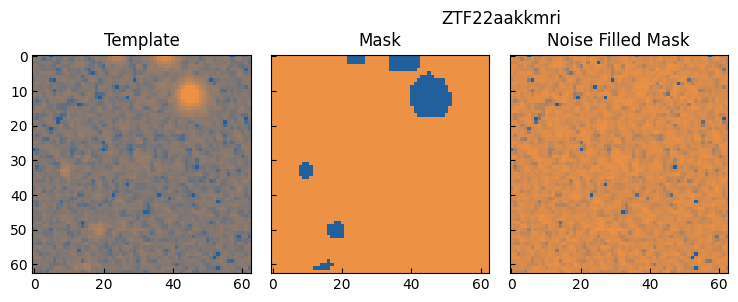

In [16]:
# Create subplots to show all 
fig, ax = plt.subplots(1, 3, figsize=(7.5, 5), sharex=True, sharey=True)
fig.suptitle(objectID, y=0.775, x=0.675)

# Show the template image
norm0 = simple_norm(stacked, 'log', percent=99.)
ax[0].imshow(stacked, norm=norm0, cmap=cmap)
ax[0].set_title('Template')
ax[0].tick_params(axis='both',direction='in')

# Show the SExtractor mask for the template image
mask = temp_seg2[0].data == 0
norm1 = simple_norm(np.where(mask, stacked, -9999), 'log', percent=99.)
ax[1].imshow(np.where(mask, stacked, -9999), norm=norm1, cmap=cmap)
ax[1].set_title('Mask')
ax[1].tick_params(axis='both',direction='in')

# Show the masked template image with the masked locations filled with random noise
mask = temp_seg2[0].data > 0
for_filling = np.random.normal(np.median(stacked[~mask]), 
                               np.std(stacked[~mask]), (63, 63))
for_filling = np.where(mask, for_filling, 0)
to_fill = np.where(mask, 0, stacked)
tpl_data = to_fill + for_filling

norm2 = simple_norm(tpl_data, 'log', percent=99.)
ax[2].imshow(tpl_data, norm=norm2,  
             cmap=cmap)
ax[2].set_title('Noise Filled Mask')
ax[2].tick_params(axis='both',direction='in')

fig.tight_layout()
plt.show()
#plt.savefig('ZTF22aakkmri_stamps.pdf', bbox_inches='tight')

In [17]:
_, _, real_Abins_dict_sta, shuffled_Abins_dict_sta = \
           ps.detect_host_with_powerspectrum(tpl_image=stacked, 
                                             metric='kstest', number_of_iterations=1000)


N_iter = 1000
size = 7

WD_dist_real_to_shuffled_sta = []
WD_dist_shuffled_to_shuffled_sta = []

for n in range(N_iter):

    iter1 = shuffled_Abins_dict_sta[size][n]
    wd = wasserstein_distance(iter1, real_Abins_dict_sta[size])
    WD_dist_real_to_shuffled_sta.append(wd)

    for m in range(N_iter):
        if m >= n:
            continue
        
        iter2 = shuffled_Abins_dict_sta[size][m]
        wd = wasserstein_distance(iter1, iter2)
        WD_dist_shuffled_to_shuffled_sta.append(wd)

WD_dist_real_to_shuffled_sta = np.array(WD_dist_real_to_shuffled_sta)
WD_dist_shuffled_to_shuffled_sta = np.array(WD_dist_shuffled_to_shuffled_sta)

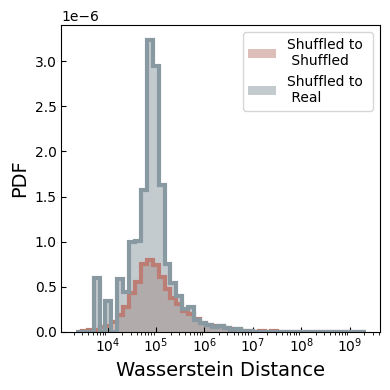

In [18]:
#bins = np.linspace(min(WD_dist_shuffled_to_shuffled), max(WD_dist_shuffled_to_shuffled), 50)
bins=np.logspace(np.log10(min(WD_dist_shuffled_to_shuffled_sta)),
                 np.log10(max(WD_dist_shuffled_to_shuffled_sta)), 50)

fig, ax = plt.subplots(1,1, figsize=(4, 4))

ax.hist(WD_dist_shuffled_to_shuffled_sta, bins, color=colors['rose'], alpha=0.5, density=True, 
        label='Shuffled to \n Shuffled');
ax.hist(WD_dist_shuffled_to_shuffled_sta, bins, color=colors['rose'], histtype='step', lw=3, density=True);

ax.hist(WD_dist_real_to_shuffled_sta, bins, color=colors['light_gray'], alpha=0.5, density=True, 
        label='Shuffled to \n Real');
ax.hist(WD_dist_real_to_shuffled_sta, bins, color=colors['light_gray'], histtype='step', lw=3, density=True);

ax.set_xlabel('Wasserstein Distance', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
ax.set_xscale('log')
ax.legend(loc='upper right', fontsize=10)
ax.tick_params(axis='both',direction='in')
fig.tight_layout()
#plt.savefig('ZTF22aakkmri_hist.pdf', bbox_inches='tight')
plt.show()